**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image0]: ./output_images/camera_distort.png "Camera Distortion"
[image1]: ./output_images/Original_Image.png "Original Image"
[image2]: ./output_images/Undist_Img.png "Undistorted"
[image3]: ./output_images/binary_warped.png "Binary Warped Image"
[image4]: ./output_images/color_threshold.png "Image with Color Threshold"
[image5]: ./output_images/warped_in_b.png "Warped Image Birds Eye View"
[image6]: ./output_images/result.png "Output"
[image7]: ./output_images/HLS.png "HLS color space"
[image8]: ./output_images/image_l.png "Image in L Space"
[image9]: ./output_images/image_sobel.png "Image with sobel filter"
[image10]: ./output_images/final_result.png " Final Result"

[video1]: ./save.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

## Camera Calibration


I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.


[//]: # (Image References)

[image0]: ./output_images/camera_distort.png "Camera Distortion"
[image1]: ./output_images/Original_Image.png "Original Image"
[image2]: ./output_images/Undist_Img.png "Undistorted"
[image3]: ./output_images/binary_warped.png "Binary Warped Image"
[image4]: ./output_images/color_threshold.png "Image with Color Threshold"
[image5]: ./output_images/warped_in_b.png "Warped Image Birds Eye View"
[image6]: ./output_images/result.png "Output"
[image7]: ./output_images/HLS.png "HLS color space"
[image8]: ./output_images/image_l.png "Image in L Space"
[image9]: ./output_images/image_sobel.png "Image with sobel filter"
[video1]: ./save.mp4 "Video"


In [1]:
import cv2
import glob
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

global counter
global lane_left 
global lane_right
global mtx
global dist


In [2]:
# read in images for camera calibration
file_path = os.getcwd() +  "\\"+"camera_cal"+ "\\"
images=glob.glob(file_path + "calibration*.jpg")

objpoints=[]
imgpoints=[]
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# find object points in chessboard iamge 
for image in images:
    img=cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
img_size = (gray.shape[1], gray.shape[0])

# perform camera calibration to obtain the mtx matrix 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function. A comparision between the original image and the undistorted one is presented in the following picture：

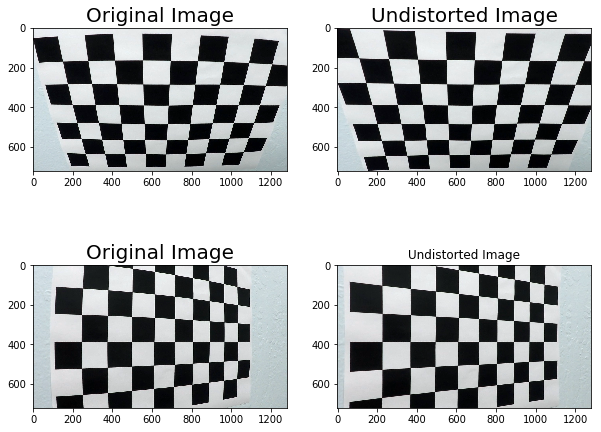

In [3]:
#Examples of undistorted chessboard image
%matplotlib inline
plt.figure(figsize=(10,8))

img = cv2.imread("camera_cal/calibration2.jpg")
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(2,2,1)
plt.title('Original Image', fontsize=20)
fig =plt.imshow(img)

plt.subplot(2,2,2)
plt.title('Undistorted Image', fontsize=20)
fig =plt.imshow(img_undist)


img = cv2.imread("camera_cal/calibration5.jpg")
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(2,2,3)
plt.title('Original Image', fontsize=20)
fig =plt.imshow(img)

plt.subplot(2,2,4)
plt.title('Undistorted Image')
fig =plt.imshow(img_undist)
#plt.savefig('camera_distort.png')

## Pipeline (images)


Here I will explain how I have build the image processing pipeline based on one example picture.

The example image I have used is shown below.

![alt text][image1]


### image Undistortion
The first step of the pipeline is to perform image distortion correction, using the camera matrix we obtained previously. The image with distortion correction is the following:

![alt text][image2]

### Color and Gradient Thresholding

In the next step  I used a combination of color and gradient thresholds to generate a binary image. I used color transformation to translate the image from rgb space into hls color space. HLS stands for "Hue", "Saturation" and "Lightness", and the color space can be presented by this picture:

![alt text][image7]

Through converting the image into HSL space I am able to seperate the influence of lighting condition, because the image in L-Space is not dependent on the lightness of the image. The picture in L-Space is shown below:

![alt text][image8]

Another filter I have used is the sobel operation for finding the gradients in x direction. Because the Lanes will normally have a large gradient in the x-direction, I can find filter out by setting a certain miminal threshold for gradient in x directon. The result I obtain is the following: 

![alt text][image9]

### Perspective Transform
The next step to do is to transform the picture into bird eyes view, thus we can calculate the curvature. To do this, I used the warpPerspective function provided by cv2 library. To do that I need to define the source and destination points of the image. I used the ones provided in the template and find the result very satisfying. The values are:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

And the warped image in birds eye view becomes:

![alt text][image5]

Combined with the color and gradient thresholding method, we finally obtain the following image:

![alt text][image3]

### Polynomial Fit

After we obtained the binary warped image, we can starting looking for the lanes. Here I used the sliding window search algorithm introduced in the class. I did this by creating a histogram of the buttom side of the image, and finding maximum values in the left and right halves of the image. The peaks in the histogram will most likely be the x position of the lane. The image is plit into 9 horizontal slices. And starting from the bottom slice, we enclose a 100 pixel wide window around the left peak and right peak of the histogram, and perform mean calculation of all the pixel values. This value will be used as the starting value of the next slice. 

After obtaining two groups of pixels which will most likely be our left and right lane, we can fit a second order polynomial to each pixel group, which will be our left and right lane. 

This part is realized by the function 'FitLanes'.


### Measuring Curvature and Calculating Offset

With the polynomial fit for the left and right lane lines, we can calculated the radius of curvature according to formula introduced in the class, which is also explained [here](http://www.intmath.com/applications-differentiation/8-radius-curvature.php).I converted the distance units from pixels to meters, with the assumption of 30 meters per 720 pixels in the vertical direction, and 3.7 meters per 700 pixels in the horizontal direction. I took the average radius of the left and right lanes and obtained the radius of the lane.

Given the polynomial fit for the left and right lane lines, we can calculated the offset between the vehicle and the the lane center. We can make the assuption that the vehicle's center is the center of the image. I calculated the lane's center as the mean x value of the bottom x value of the left lane line, and bottom x value of the right lane line. The offset is then the center of the vehicle substracted by the lane center. 

The lane radius ad the vehicle's offset from the center are both displayed in the output video stream. This part is realized by the function 'curvature'.


### Display Result 
Now that we have found the lanes and calculated the curvature and the offset, the final step is to warp the image back into the original image and display the results. The output of the image pipeline is shown below. 

![alt text][image10]

### Pipeline (Video)

When we a processing a video, we can use the same pipeline for the image, because a video is only a sequence of many image. But an advange when processing a video is that we can assume that the lanes detected in different image frames are correlating and there will not be large jumpes between two connecting images. 

To store some information about the lane in the previous running cycles and build up a history of the lane object, I created a class called Line and defined the two attributes "detected" and "last_poly_coeff". In the attribute "last_poly_coeff", the coefficients of the lane in the current picture is stored and used as a starting value of the next picture. As suggsted in the learning material, I also tried out using more attributes such as "best_fit" and "recent_xfitted", where I store  the polynomial coefficients averaged over the last n iterations, and the x values of the last n fits of the line. These Information can be used when the lane detected in the current picture largely differs from the previous experience value. 


### Discussion

When I first ran my image processing pipeline, the lane detection algorithm was working overall but the lanes are jumping sometimes, despite all the sanity checks I have added. It took me two days until I have detected that the error was already made during the camera calibration step, because I always assumed that my tracking algorithm was wrong. I have falsely put the camera calibration function inside the loop where I read in all the chessboard images for calibration. After I corrected this, The pipeline was working fine for the normal project video, even without any sanity checks. Due to timing reason I was not able to get a perfect line fitting algorithm of the challenging video, but I believe with that with enough sanity checks it will work as well. 






In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.last_poly_coeff = [np.array([False])]  
lane_left = Line()
lane_right = Line()

In [5]:
def unwarp(img, src, dst, M_warp):
    h,w = img.shape[:2]
    warped = cv2.warpPerspective(img, M_warp, (w,h), flags=cv2.INTER_LINEAR)
    return warped

In [6]:
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):

    # convert image in rgb to hsl space
    img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # taking the gradient in x and y direction 
    sobelx1 = cv2.Sobel(img_hsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(img_hsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # scaling  
    sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(sobelx1)
    binary_outputx1[(sobelx1 >= min_thres) & (sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(sobelx2)
    binary_outputx2[(sobelx2 >= min_thres) & (sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output

In [7]:
def create_output_img(undist,M_inv, warped, left_fit, right_fit):

    #create output image with lines detected
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    image_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(image_warp, np.int_([pts]), (50,205,50))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warp_inv = cv2.warpPerspective(image_warp, M_inv, (image_warp.shape[1], image_warp.shape[0]))
    
    # Combine the result with the original image
    img_out = cv2.addWeighted(undist, 1, warp_inv, 0.3, 0)
    return img_out

In [8]:
def FitLanes(binary_warped):
    global counter
    global lane_left 
    global lane_right
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # creating histogram of the image for x axis
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

       
    # find maximal value in the left and right half of the image histogram,
    # which most likely represent the position of the left and right lane.
    leftx_lane = np.argmax(histogram[:np.int(histogram.shape[0]/2)])
    rightx_lane = np.argmax(histogram[np.int(histogram.shape[0]/2):]) + np.int(histogram.shape[0]/2)

    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # width of the searching windows 
    margin = 100
    # minimum number of pixels found in a window
    minpix = 50
    
    if counter>1:
        # if we already have a history of the lane, then we can recalculate basd on that history
        lft_poly=lane_left.last_poly_coeff
        rgt_poly= lane_right.last_poly_coeff
        left_lane_inds = ((nonzerox > (lft_poly[0]*(nonzeroy**2) + lft_poly[1]*nonzeroy + lft_poly[2] - margin)) & (nonzerox < (lft_poly[0]*(nonzeroy**2) + lft_poly[1]*nonzeroy + lft_poly[2] + margin))) 
        right_lane_inds = ((nonzerox > (rgt_poly[0]*(nonzeroy**2) + rgt_poly[1]*nonzeroy + rgt_poly[2] - margin)) & (nonzerox < (rgt_poly[0]*(nonzeroy**2) + rgt_poly[1]*nonzeroy + rgt_poly[2] + margin)))  
    else:
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):

            win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
            win_y_high = int(binary_warped.shape[0] - window*window_height)
            win_xleft_low = int(leftx_lane - margin)
            win_xleft_high = int(leftx_lane + margin)
            win_xright_low = int(rightx_lane - margin)
            win_xright_high = int(rightx_lane + margin)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_lane = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_lane = np.int(np.mean(nonzerox[good_right_inds]))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)

    lane_right.last_poly_coeff=right_fit
    lane_left.last_poly_coeff = left_fit  

 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

In [9]:
def display_result(binary_warped, left_fit,right_fit,out_img):

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #plt.figure(figsize=(30,20))
    #plt.subplot(2,1,1)
    plt.title("Binary Warped", fontsize=20)
    plt.imshow(binary_warped, cmap='gray')
    #plt.savefig('binary_warped')

    #plt.subplot(2,1,2)
    binary_warped2 = np.zeros((720, 1280,3))
    binary_warped2[:,:,0] = binary_warped
    binary_warped2[:,:,1] = binary_warped
    binary_warped2[:,:,2] = binary_warped
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
    plt.title("Lanes detected", fontsize=20)
    plt.imshow(result)
    #plt.savefig('result')

In [10]:
def curvature(left_fit, right_fit, binary_warped):
    global lane_left 
    global lane_right
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_curv = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curv = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 750)*xm_per_pix
    curv= (left_curv+right_curv)/2

    return curv, center

In [11]:
def FindLaneInImage(ImgRGB, bVisualize=0):

    global counter
    global lane_left 
    global lane_right
    global mtx
    global dist
    
    
    Img_undistort = cv2.undistort(ImgRGB,mtx,dist,None,mtx)
    # Visualize undistortion
    if bVisualize ==1:
        plt.title('Original Image', fontsize=30)
        plt.imshow(ImgRGB)
        #plt.savefig('Original_Image.png')
        plt.title('Undistorted Image', fontsize=30)
        plt.imshow(Img_undistort)
        #plt.savefig('Undist_Img.png')
    h,w = Img_undistort.shape[:2]
    # define source and destination points for transform
    left_buttom = (200, 720)
    left_top=(585,450)
    right_buttom=(1130,720)
    right_top=(695,450)

    src = np.float32([ left_top,
                      left_buttom, 
                      right_buttom, 
                      right_top])
    

    left_buttom = (320, 720)
    left_top=(320,0)
    right_buttom=(960,720)
    right_top=(960,0)
    dst = np.float32([left_top, left_buttom, right_buttom, right_top])
   

    M_warp = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    Img_unwarp = unwarp(Img_undistort, src, dst,M_warp)

    # Visualize unwarp
    if bVisualize ==1:
        plt.title('Warped Image in Birdsview', fontsize=20)
        plt.imshow(Img_unwarp)
        #plt.savefig('warped_in_b.png')
        
    image_hls= cv2.cvtColor(Img_undistort, cv2.COLOR_RGB2HSV)
    if(bVisualize ==1):
        plt.title('HSL Image in H Channel', fontsize=20)
        plt.imshow(image_hls[:,:,0],cmap ='gray')
        #plt.savefig('image_h.png',cmap ='gray')
        plt.title('HSL Image in L Channel', fontsize=20)
        plt.imshow(image_hls[:,:,1],cmap ='gray')
        #plt.savefig('image_l.png',cmap ='gray')
        plt.title('HSL Image in S Channel', fontsize=20)
        plt.imshow(image_hls[:,:,2],cmap ='gray')
        #plt.savefig('image_s.png',cmap ='gray')
    
    binary_output_yellow = np.zeros((image_hls.shape[0], image_hls.shape[1]))
    binary_output_white = np.zeros((image_hls.shape[0], image_hls.shape[1]))
    
    binary_output_yellow[(image_hls[:,:,0] >= 0) & (image_hls[:,:,0] <= 50) & (image_hls[:,:,1] >= 100)  & (image_hls[:,:,1] <= 255)  & (image_hls[:,:,2] >= 100) & (image_hls[:,:,2] <= 255)] = 1
    binary_output_white[(image_hls[:,:,0] >= 18) & (image_hls[:,:,0] <= 255) & (image_hls[:,:,1] >= 0)  & (image_hls[:,:,1] <= 80)  & (image_hls[:,:,2] >= 180) & (image_hls[:,:,2] <= 255)] = 1

    img_color_thresh =np.zeros_like(binary_output_yellow)
    img_color_thresh[(binary_output_yellow==1) | (binary_output_white==1)] =1
    img_sobelx_thresh = sobel_x(Img_undistort,9,80,220) 
    if(bVisualize ==1):
        plt.title('Image with sobelx filter', fontsize=20)
        plt.imshow(img_sobelx_thresh,cmap ='gray')
        #plt.savefig('image_h.png',cmap ='gray')
        
    img_thresh =np.zeros_like(binary_output_yellow)
    img_thresh[(binary_output_yellow==1) | (binary_output_white==1) | (img_sobelx_thresh==1)] =1
    binary_warped = cv2.warpPerspective(img_thresh, M_warp, (w,h), flags=cv2.INTER_LINEAR)

    if bVisualize == 1:
        plt.title('Image with color threshold', fontsize=20)
        plt.imshow(img_color_thresh,cmap ='gray')
        #plt.savefig('color_threshold.png')
        plt.title('Warped Image with threshold', fontsize=20)
        plt.imshow(binary_warped,cmap ='gray')
        #plt.savefig('warped_image.png')
        

    left_fit, right_fit, out_img  = FitLanes(binary_warped)
    if bVisualize == 1:
        display_result(binary_warped, left_fit,right_fit,out_img)
        
  
    curv, center_off = curvature(left_fit, right_fit, binary_warped)
    
        #Warp back to original and merge with image    
    img_out = create_output_img(Img_undistort, M_inv, binary_warped,left_fit, right_fit)

    #Write curvature and center in image
    Test_Curv = "Curvature is: " + str(int(curv)) + " m"
    Text_Offset = "Center offset is: " + str(round( center_off,2)) + "m"
    fontScale=1
    thickness=2
    
    fontScale = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_out,Test_Curv,(10,100),  fontScale, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img_out,Text_Offset,(20,200),  fontScale, 2,(255,255,255),2,cv2.LINE_AA)
    counter = counter+1
    return img_out

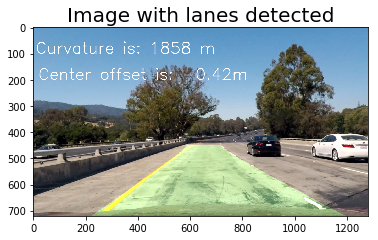

In [12]:
image_path='./test_images/test1.jpg'
ImgBGR = cv2.imread(image_path)
plt.title('Test Image', fontsize=20)
plt.imshow(ImgBGR)
ImgRGB = cv2.cvtColor(ImgBGR, cv2.COLOR_BGR2RGB)
bVisualize=0
counter=0
img_out=FindLaneInImage(ImgRGB, bVisualize)

plt.title('Image with lanes detected', fontsize=20)
plt.imshow(img_out,cmap ='gray')
plt.savefig('final_result.png')

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [14]:
#Create video file pipeline
counter=0


output = '2010.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)

out_clip = clip1.fl_image(FindLaneInImage) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)



[MoviePy] >>>> Building video 2010.mp4
[MoviePy] Writing video 2010.mp4


 98%|██████████████████████████████████████████████████████████████████████▌ | 50/51 [00:11<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 2010.mp4 

Wall time: 12.2 s
51


In [15]:
from IPython.display import HTML
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))